In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

print(torch.__version__)
print(torchvision.__version__)
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

from going_modular import data_setup, engine

2.1.0+cu118
0.16.0+cu118


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78fc780c7ed0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78fc780a1ed0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [12]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [14]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [15]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9131 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7911 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7462 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6372 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6260 | test_acc: 0.8561
[INFO] Total training time: 3.875 seconds


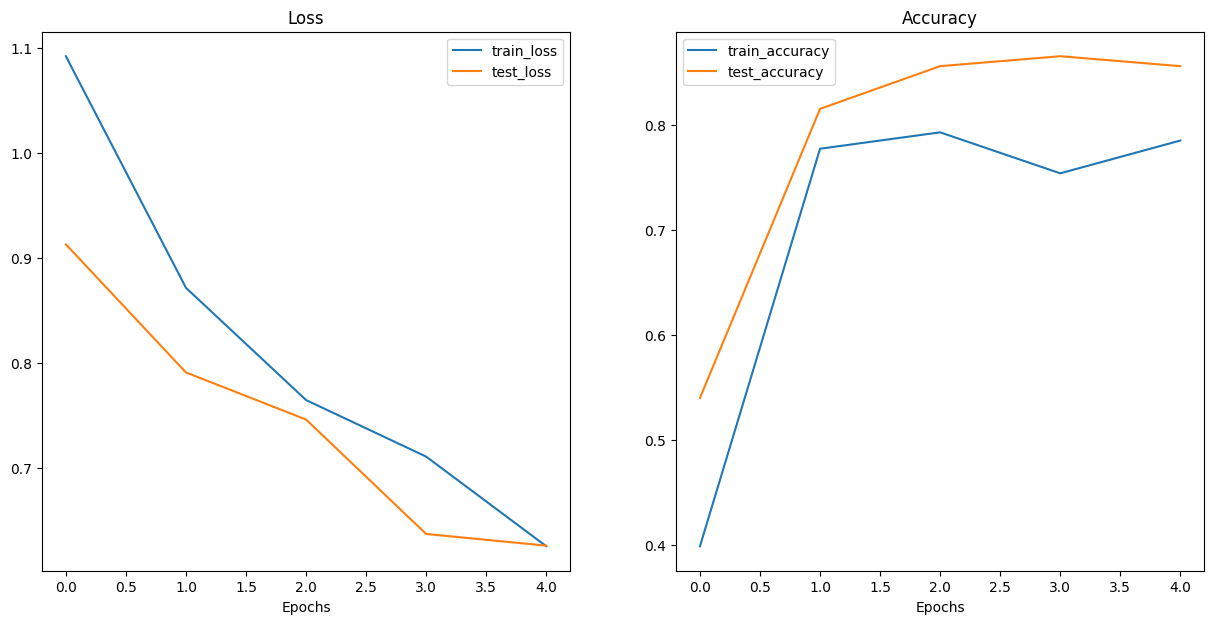

In [17]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [18]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

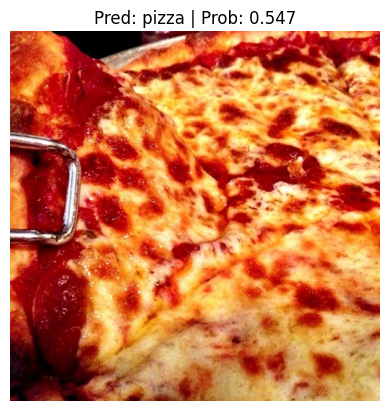

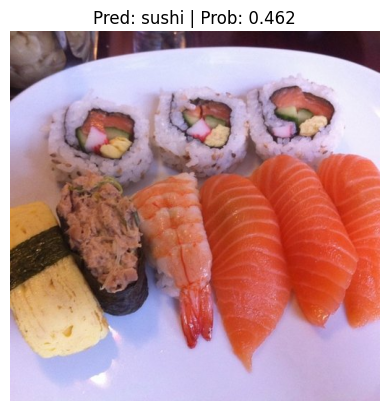

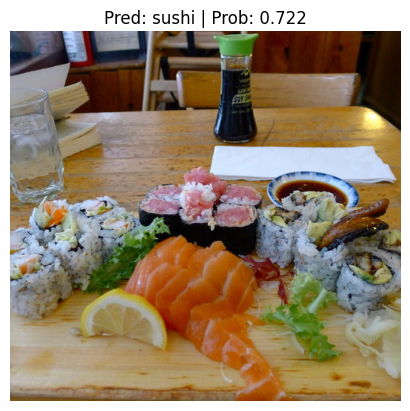

In [19]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

data/04-pizza-dad.jpeg already exists, skipping download.


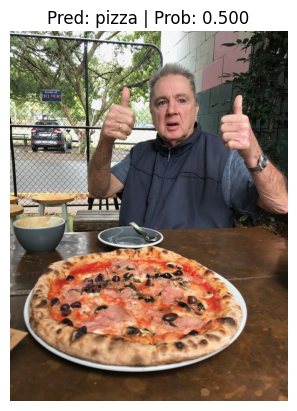

In [20]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

exercise:
1.Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for ideas.

In [21]:
# Make predictions across all test data
from tqdm.auto import tqdm
model.eval()
y_preds = []
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model(X)
    # Logits -> Pred probs -> Pred label
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
len(y_preds)

0it [00:00, ?it/s]

75

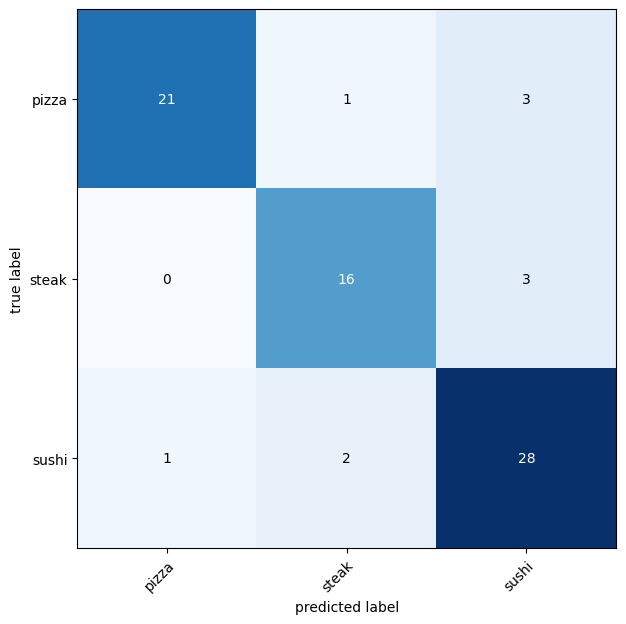

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchvision import datasets
import numpy as np

test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)
test_data = torch.from_numpy(np.asarray(test_data.targets))
# Setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

2.Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
Predicting across all of the test dataset, storing the labels and predicted probabilities.
Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
Plot the top 5 "most wrong" images, why do you think the model got these wrong?

In [23]:
# Make predictions across all test data
from tqdm.auto import tqdm
model.eval()
y_preds = []
y_preds_probs = []
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model(X)
    # Logits -> Pred probs -> Pred label
    # Append probs to probs list
    y_pred_probs = torch.max(torch.softmax(y_pred_logits, dim=1), 1)
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds_probs.append(y_pred_probs.values)
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
  y_preds_probs=torch.cat(y_preds_probs).cpu()

0it [00:00, ?it/s]

In [24]:
y_preds_probs

tensor([0.7203, 0.5327, 0.5267, 0.5903, 0.4910, 0.5038, 0.4889, 0.5373, 0.7033,
        0.7635, 0.4649, 0.4851, 0.5597, 0.5082, 0.5290, 0.3967, 0.4771, 0.5725,
        0.6606, 0.6809, 0.4977, 0.4197, 0.5371, 0.6750, 0.3867, 0.8194, 0.8430,
        0.4903, 0.7325, 0.4131, 0.8437, 0.8177, 0.7036, 0.6873, 0.3870, 0.8502,
        0.8786, 0.5356, 0.3883, 0.7846, 0.8243, 0.8191, 0.7487, 0.5907, 0.5032,
        0.4399, 0.4324, 0.4690, 0.6276, 0.8826, 0.5650, 0.4362, 0.5452, 0.5893,
        0.7002, 0.4166, 0.6042, 0.7791, 0.3883, 0.6349, 0.4611, 0.7691, 0.4628,
        0.4890, 0.4011, 0.5056, 0.5656, 0.6234, 0.6547, 0.6848, 0.4313, 0.4441,
        0.4341, 0.4349, 0.5943])

In [25]:
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [26]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=auto_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8827303647994995,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4167293310165405,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.462848037481308,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4319286048412323,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.46926024556159973,
  'pred_class': 'sushi',
  'correct': True}]

In [27]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
74  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza   0.559215   
56  data/pizza_steak_sushi/test/pizza/2871261.jpg      pizza   0.507863   
40  data/pizza_steak_sushi/test/steak/1285886.jpg      steak   0.490404   
64   data/pizza_steak_sushi/test/pizza/344397.jpg      pizza   0.477439   
16   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.431286   

   pred_class  correct  
74      sushi    False  
56      steak    False  
40      sushi    False  
64      sushi    False  
16      steak    False

/tmp/ipykernel_7784/410343107.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipykernel_7784/410343107.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipykernel_7784/410343107.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
/tmp/ipykernel_7784/410343107.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

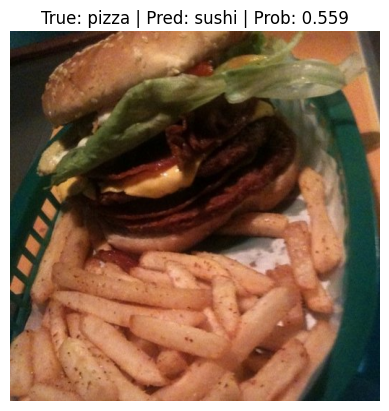

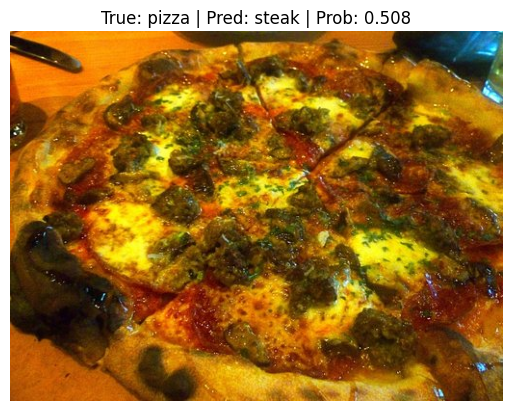

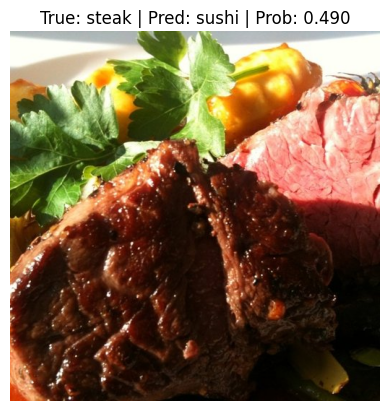

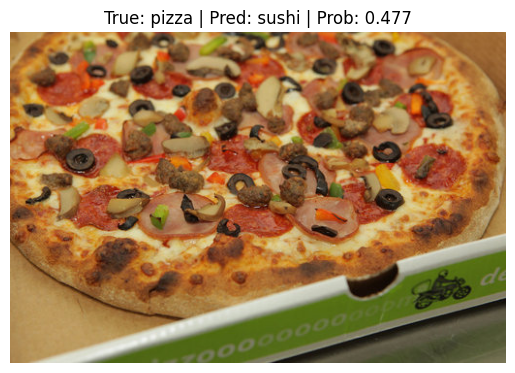

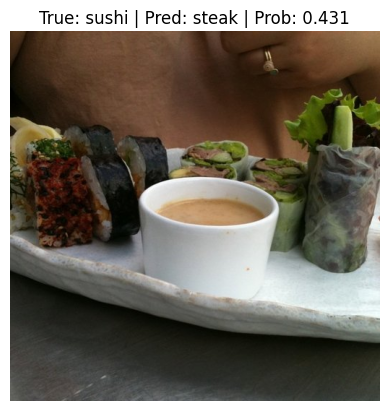

In [28]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

3.Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

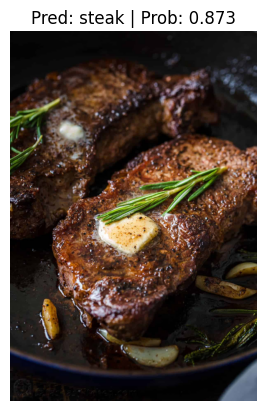

In [31]:
# Download custom image
import requests

# Setup custom image path
custom_image_path1 = data_path / "steak.jpeg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path1,
                    class_names=class_names)

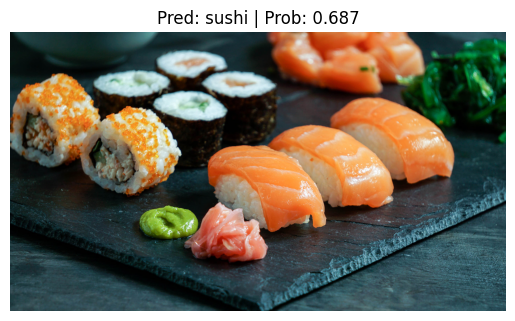

In [32]:
# Download custom image
import requests

# Setup custom image path
custom_image_path2 = data_path / "sushi.jpeg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path2,
                    class_names=class_names)

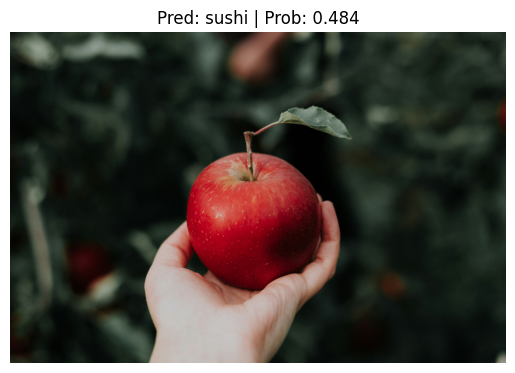

In [33]:
# Download custom image
import requests

# Setup custom image path
custom_image_path3 = data_path / "apple.jpg"

# Download the image if it doesn't already exist
if not custom_image_path3.is_file():
    with open(custom_image_path3, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a")
        print(f"Downloading {custom_image_path3}...")
        f.write(request.content)
else:
    print(f"{custom_image_path3} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path3,
                    class_names=class_names)

4.Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [34]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results1 = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5289 | train_acc: 0.9258 | test_loss: 0.5674 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4793 | train_acc: 0.9297 | test_loss: 0.5214 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4518 | train_acc: 0.9219 | test_loss: 0.5249 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4759 | train_acc: 0.8398 | test_loss: 0.4814 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4073 | train_acc: 0.9570 | test_loss: 0.4942 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4402 | train_acc: 0.8203 | test_loss: 0.4728 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.4078 | train_acc: 0.9453 | test_loss: 0.4560 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.4279 | train_acc: 0.8320 | test_loss: 0.4499 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5003 | train_acc: 0.8242 | test_loss: 0.4425 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4109 | train_acc: 0.8320 | test_loss: 0.3862 | test_acc: 0.9062
[INFO] Total training time: 7.461 seconds


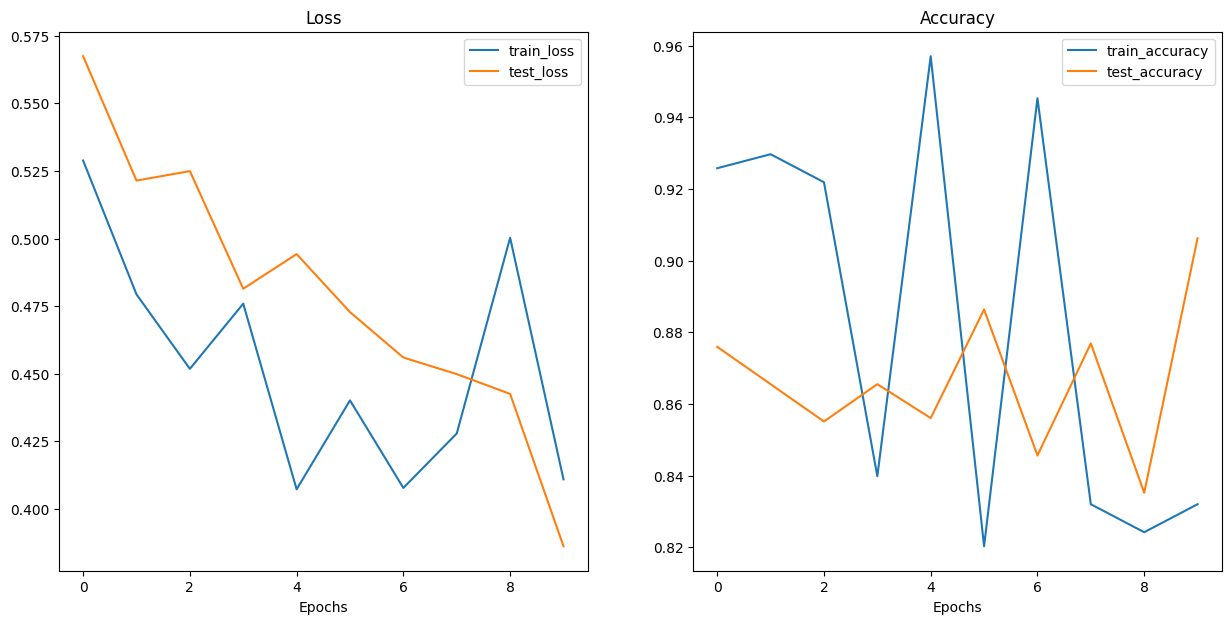

In [35]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results1)

5.Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was created with the notebook extras/04_custom_data_creation.ipynb.

In [37]:
image_path_20_percent = data_path / "pizza_steak_sushi_20_percent"
# Setup Dirs
train_dir_20_percent = image_path_20_percent / "train"
test_dir_20_percent = image_path_20_percent / "test"

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir_20_percent,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78fd4e55d650>,
 ['pizza', 'steak', 'sushi'])

In [38]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results2 = engine.train(model=model,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4391 | train_acc: 0.8646 | test_loss: 0.3666 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.3932 | train_acc: 0.8771 | test_loss: 0.3398 | test_acc: 0.9136
Epoch: 3 | train_loss: 0.4402 | train_acc: 0.8292 | test_loss: 0.3143 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.3122 | train_acc: 0.9062 | test_loss: 0.3117 | test_acc: 0.9006
Epoch: 5 | train_loss: 0.3424 | train_acc: 0.9062 | test_loss: 0.3136 | test_acc: 0.9108
[INFO] Total training time: 4.360 seconds


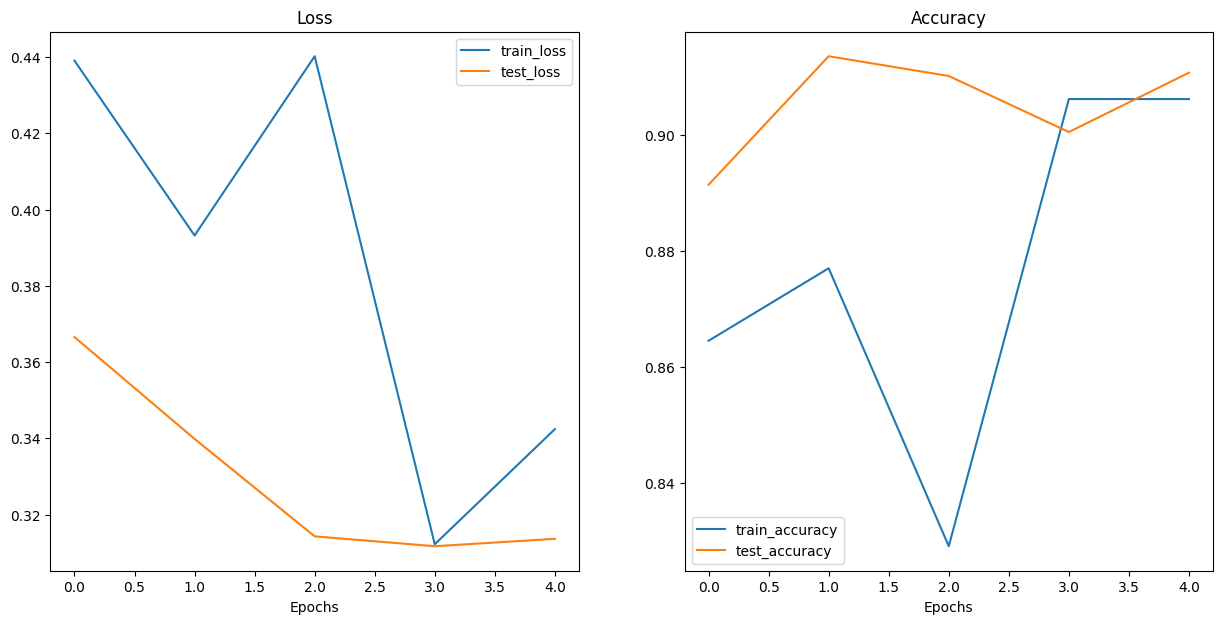

In [39]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results2)

6.Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?
You'll have to change the size of the classifier layer to suit our problem.
You may want to try an EfficientNet with a higher number than our B0, perhaps torchvision.models.efficientnet_b2()?

In [40]:
# Get a set of pretrained model weights
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights_b2

EfficientNet_B2_Weights.IMAGENET1K_V1

In [41]:
# Get the transforms used to create our pretrained weights
auto_transforms_b2 = weights_b2.transforms()
auto_transforms_b2

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [42]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader_b2, test_dataloader_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms_b2, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader_b2, test_dataloader_b2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78fd4e41a250>,
 ['pizza', 'steak', 'sushi'])

In [44]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
model_b2 = torchvision.models.efficientnet_b2(weights=weights_b2).to(device)

model_b2 # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [45]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_b2, 
        input_size=(32, 3, 288, 288), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 16, 144

In [47]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_b2.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1408, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary(model_b2, 
        input_size=(32, 3, 288, 288), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

In [48]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_b2 = engine.train(model=model_b2,
                       train_dataloader=train_dataloader_b2,
                       test_dataloader=test_dataloader_b2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1272 | train_acc: 0.2852 | test_loss: 1.0795 | test_acc: 0.3703
Epoch: 2 | train_loss: 1.1463 | train_acc: 0.2617 | test_loss: 1.0998 | test_acc: 0.3087
Epoch: 3 | train_loss: 1.1513 | train_acc: 0.2891 | test_loss: 1.0913 | test_acc: 0.3504
Epoch: 4 | train_loss: 1.1153 | train_acc: 0.3047 | test_loss: 1.0830 | test_acc: 0.3797
Epoch: 5 | train_loss: 1.1243 | train_acc: 0.2383 | test_loss: 1.0901 | test_acc: 0.2775
[INFO] Total training time: 4.682 seconds


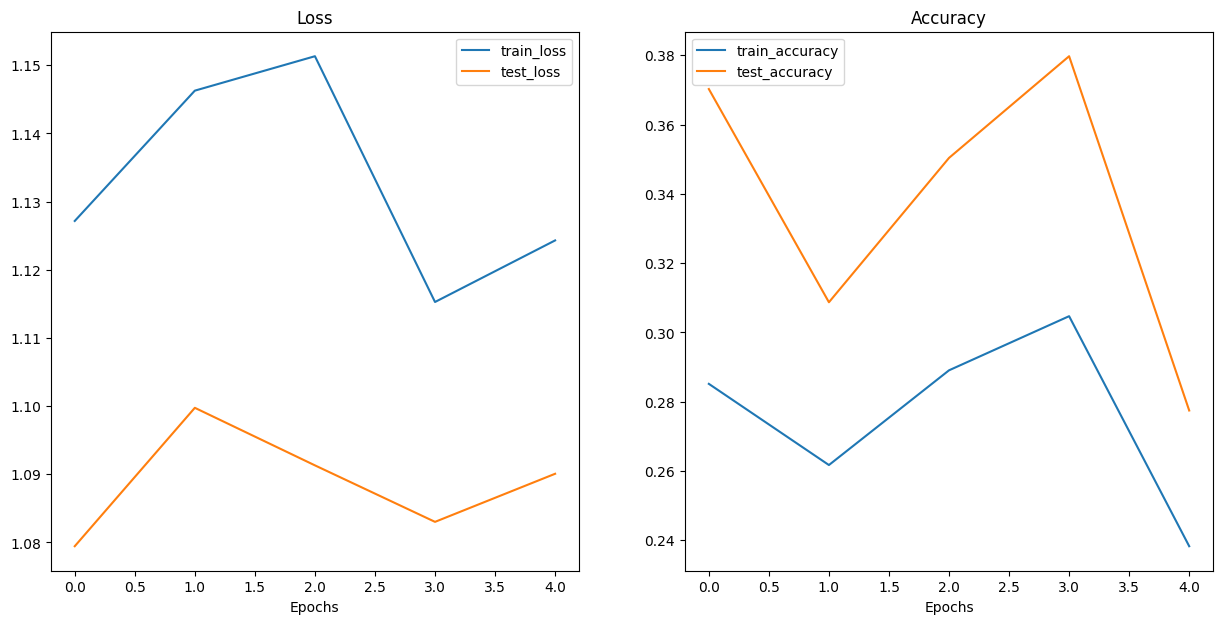

In [50]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_b2)

it turns out the torchvision.models.efficientnet_b2() performs much more bad than torchvision.models.efficientnet_b0()